In [6]:
system("conda install r-ape=5.8_1 r-rnaturalearth=1.1.0 r-rnaturalearthdata=1.0.0 r-gdalUtilities=1.2.5 r-rotl=3.1.0 r-sf=1.0_20")

In [7]:
install.packages("pdindicatoR", repos = "https://b-cubed-eu.r-universe.dev")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [8]:
# Load packages
library(pdindicatoR)

library(sf)      # working with spatial objects
library(dplyr)   # data wrangling

Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Loading example data

For this example workflow, we will be using the example data that is included in the pdindicatoR package. The example data can be loaded by using the function `retrieve_example_data()`

In [9]:
ex_data <- retrieve_example_data()
tree <- ex_data$tree 
cube <- ex_data$cube 
grid <- ex_data$grid
pa <- ex_data$pa

Reading layer `EEA_1km_HK' from data source 
  `/opt/conda/envs/rlang-kernel/lib/R/library/pdindicatoR/extdata/EEA_1km_NPHogeKempen/EEA_1km_HK.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4108 features and 7 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 3974000 ymin: 3068000 xmax: 4051000 ymax: 3125000
Projected CRS: ETRS89-extended / LAEA Europe
Reading layer `protected_areas_NPHogeKempen' from data source 
  `/opt/conda/envs/rlang-kernel/lib/R/library/pdindicatoR/extdata/PA_NPHogeKempen/protected_areas_NPHogeKempen.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 32 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 3948585 ymin: 3065773 xmax: 4049889 ymax: 3141858
Projected CRS: ETRS89-extended / LAEA Europe


## Inspect tree and cube
We plot the tree and print the first lines of the occurrence cube to confirm they are processed correctly.

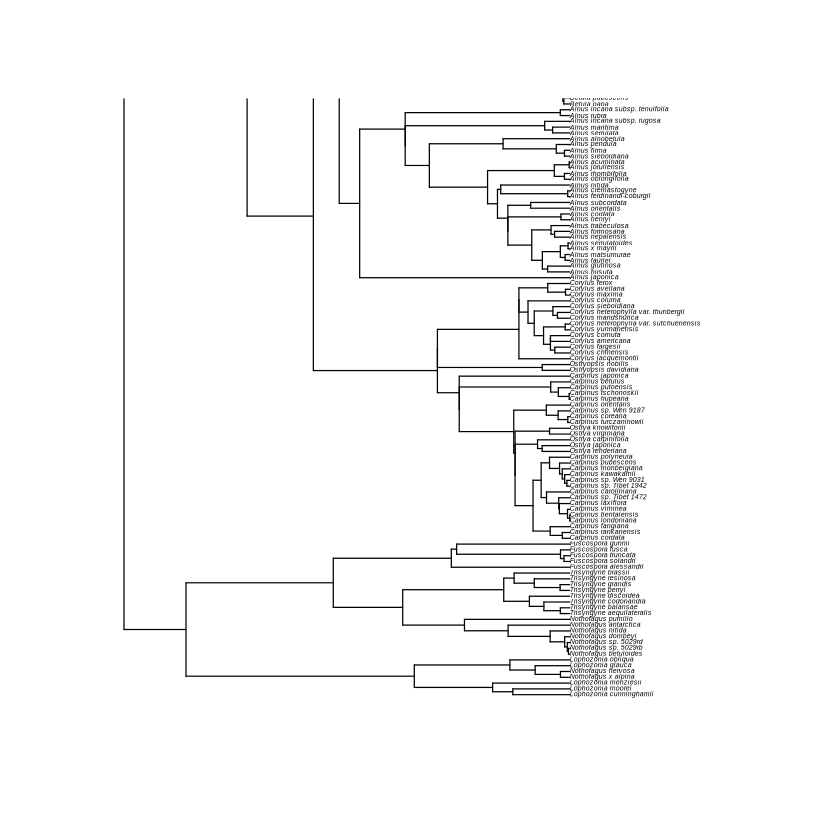

In [10]:
options(width = 1000)
plot(tree, cex = 0.35, y.lim = 100)

In [11]:
head(cube)

,year,eeacellcode,specieskey,species,establishmentmeans,degreeofestablishment,pathway,occurrences,distinctobservers
,<int>,<chr>,<int>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>
1,2024,1kmE3996N3087,2880539,Quercus rubra,,NA,NA,1,1
2,2024,1kmE3997N3088,3054357,Juglans nigra,,NA,NA,2,1
3,2024,1kmE3997N3090,3054368,Juglans regia,,NA,NA,1,1
4,2024,1kmE3997N3100,2880539,Quercus rubra,,NA,NA,1,1
5,2024,1kmE3997N3104,5333294,Castanea sativa,,NA,NA,1,1
6,2024,1kmE3997N3104,8313153,Quercus palustris,,NA,NA,1,1


## Matching species in phylogenetic tree and datacube
The leaf labels of a phylogenetic tree downloaded from the OTL database are specified as either species names or OTL id’s (`ott_id`). We can use the function `taxonmatch()` to retrieve the corresponding GBIF id’s.

In [13]:
matched <- taxonmatch(tree)
head(matched)

,search_string,unique_name,approximate_match,score,ott_id,is_synonym,flags,number_matches,gbif_id,orig_tiplabel
,<chr>,<chr>,<lgl>,<dbl>,<int>,<lgl>,<chr>,<int>,<int>,<chr>
1,alfaroa costaricensis,Alfaroa costaricensis,FALSE,1,199041,FALSE,,1,7310550,Alfaroa costaricensis
2,alfaroa guanacastensis,Alfaroa guanacastensis,FALSE,1,199043,FALSE,,2,NA,Alfaroa guanacastensis
3,alfaroa manningii,Alfaroa manningii,FALSE,1,199049,FALSE,,1,4205554,Alfaroa manningii
4,alfaroa williamsii,Alfaroa williamsii,FALSE,1,1064109,FALSE,,1,7310534,Alfaroa williamsii
5,alfaropsis,Alfaropsis,FALSE,1,200433,FALSE,barren,2,NA,Alfaropsis
6,allocasuarina acutivalvis,Allocasuarina acutivalvis,FALSE,1,769753,FALSE,,1,2891875,Allocasuarina acutivalvis


Carefully evaluate the table with matches to ensure that matching scores are acceptable and that most species have a corresponding `gbif_id`. Species that cannot be reliable matched or that don’t have an associated `gbif_id`, can not contribute to the PD calculation and should be removed.

In [14]:
matched_nona <- matched %>%
  dplyr::filter(!is.na(gbif_id))

Then, we can use the function `append_ott_id()` to append the `ott_id`’s as a new variable to the provided datacube, by joining on `gbif_id`.

In [15]:
mcube <- append_ott_id(tree, cube, matched_nona)
head(mcube)

,year,eeacellcode,specieskey,species,establishmentmeans,degreeofestablishment,pathway,occurrences,distinctobservers,ott_id,unique_name,orig_tiplabel
,<int>,<chr>,<int>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>,<chr>
1,2024,1kmE3996N3087,2880539,Quercus rubra,,NA,NA,1,1,791115,Quercus rubra,Quercus rubra
2,2024,1kmE3997N3088,3054357,Juglans nigra,,NA,NA,2,1,1072887,Juglans nigra,Juglans nigra
3,2024,1kmE3997N3090,3054368,Juglans regia,,NA,NA,1,1,138717,Juglans regia,Juglans regia
4,2024,1kmE3997N3100,2880539,Quercus rubra,,NA,NA,1,1,791115,Quercus rubra,Quercus rubra
5,2024,1kmE3997N3104,5333294,Castanea sativa,,NA,NA,1,1,1028994,Castanea sativa,Castanea sativa
6,2024,1kmE3997N3104,8313153,Quercus palustris,,NA,NA,1,1,538292,Quercus palustris,Quercus palustris


When species in the datacube are not included in the provided phylogenetic tree, the `ott_id` variable will be NA. We can use the function `check_completeness()` to see how complete the provided phylogenetic tree is.

In [16]:
check_completeness(mcube)

The following species are not part of the provided phylogenetic tree:
   specieskey                 species
1     9148577            Alnus incana
2          NA                        
3     2880130         Quercus petraea
4     2880580          Quercus cerris
5     8288647 Pterocarya fraxinifolia
6     2879292         Quercus rosacea
7     2879520        Quercus conferta
8     2876571         Alnus pubescens
9     7797155           Alnus hirsuta
10    2880652         Quercus phellos


Please note that occurrence records for species that are not part of the provided phylogenetic tree will need to be removed. In case this number is large, please consider searching for a more complete phylogenetic tree that covers all your species!

In [17]:
mcube <- mcube %>%
  dplyr::filter(!is.na(ott_id))

## Calculate Phylogenetic Diversity for each grid cell
We can used the function `get_pd_cube()` to calculate the PD values per gridcell. This function first creates a new aggregated cube, with a list of observed species for each grid cell. The optional argument timegroup can be used to indicate a time interval for which the PD metrics should be calculated, e.g. `timegroup = 5` calculates PD for all occurrences observed within a timespan of 5 years and produces a separate map and indicator for each period. If no `timegroup` argument is specified, all occurrences in the dataset will be aggregated over time. The argument `metric` can be used to specify which PD metric needs to be calculated. The PD values will be appended to the datacube as a new column ‘PD’.

In [18]:
pd_cube <- get_pd_cube(mcube, tree, metric = "faith")

## Visualize PD on a map & calculate indicator
Finally we read in the EEA Grid shapefiles and merge them to the occurrence cube by joining on the eeaCellCode field. The PD cube can then be plotted and overlaid with a polygon layer depicting the boundaries of WDPA protected areas.
### Plot PD map
The function generate_map_and_indicator() can be used to generate a map visualizing phylogenetic diversity covering the geographic area that is used to generate the occurrence cube.If more detailed maps are desired, the optional argument bbox_custom can be used to delineate the bounding box. Coordinates for the desired geographic area can be determined using https://epsg.io/ and selecting the CRS of the used grid.

Reading layer `protected_areas_NPHogeKempen' from data source `/opt/conda/envs/rlang-kernel/lib/R/library/pdindicatoR/extdata/PA_NPHogeKempen/protected_areas_NPHogeKempen.shp' using driver `ESRI Shapefile'
Simple feature collection with 32 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 3948585 ymin: 3065773 xmax: 4049889 ymax: 3141858
Projected CRS: ETRS89-extended / LAEA Europe


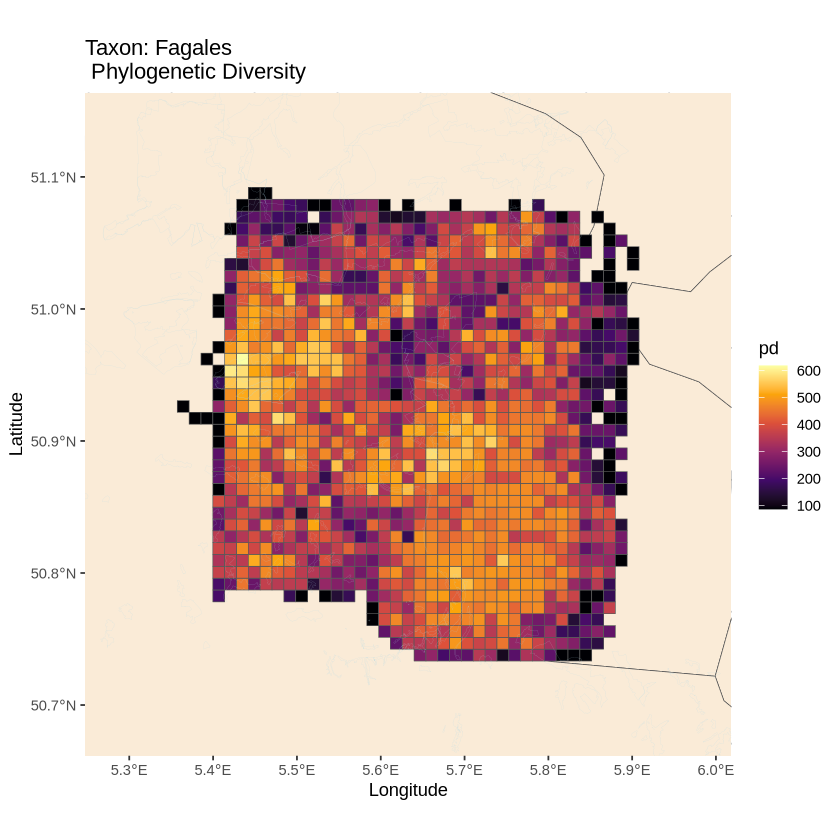

In [20]:
pdindicator <- generate_map_and_indicator(pd_cube, grid, "Fagales")
pdindicator
# Optionally specify a custom bounding box
# bbox_custom <- c(xmin,xmax,ymin,ymax)
# pdmap <- generate_map_and_indicator(pd_cube, grid, "Musteloidea", bbox_custom)

If the optional parameter `cutoff` is specified, than this value is used to classify cells as high PD cells if their PD exceeds this threshold value. An indicator value is then calculated as the percentage of high PD cell centerpoints that fall within the boundaries of protected areas. The result is stored as a list, with two maps in the first element (PD map and high/low PD map) and the indicator value as the second element.

In [21]:
pdindicator <- generate_map_and_indicator(
  pd_cube,
  grid,
  "Fagales",
  cutoff = 450)

plots <- pdindicator[[1]]
indicators <- pdindicator[[2]]

Reading layer `protected_areas_NPHogeKempen' from data source `/opt/conda/envs/rlang-kernel/lib/R/library/pdindicatoR/extdata/PA_NPHogeKempen/protected_areas_NPHogeKempen.shp' using driver `ESRI Shapefile'
Simple feature collection with 32 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 3948585 ymin: 3065773 xmax: 4049889 ymax: 3141858
Projected CRS: ETRS89-extended / LAEA Europe
Writing layer `filec349e18438' to data source `/tmp/RtmpWwBUlK/filec349e18438.gpkg' using driver `GPKG'
Writing 358 features with 4 fields and geometry type Polygon.
Reading layer `filec349e18438' from data source `/tmp/RtmpWwBUlK/filec3556dd2eb.gpkg' using driver `GPKG'
Simple feature collection with 358 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 3997000 ymin: 3081000 xmax: 4027000 ymax: 3118000
Projected CRS: ETRS89-extended / LAEA Europe


Warning message:
“st_centroid assumes attributes are constant over geometries”


[1] "The percentage of high PD grid cells that fall within protected areas is 23.46 %"


[[1]]

[[2]]


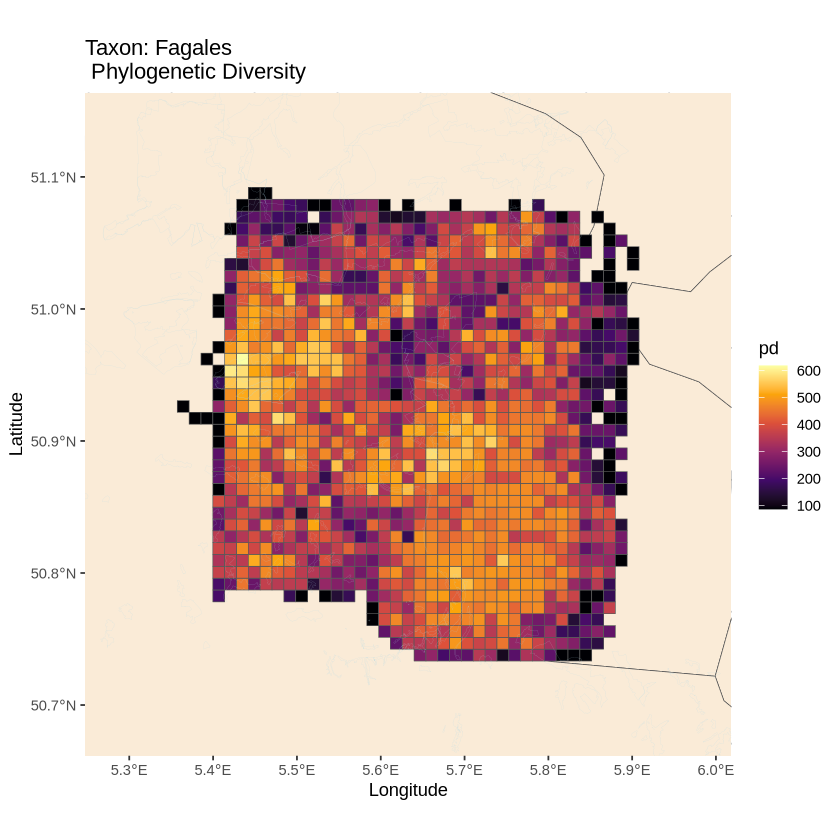

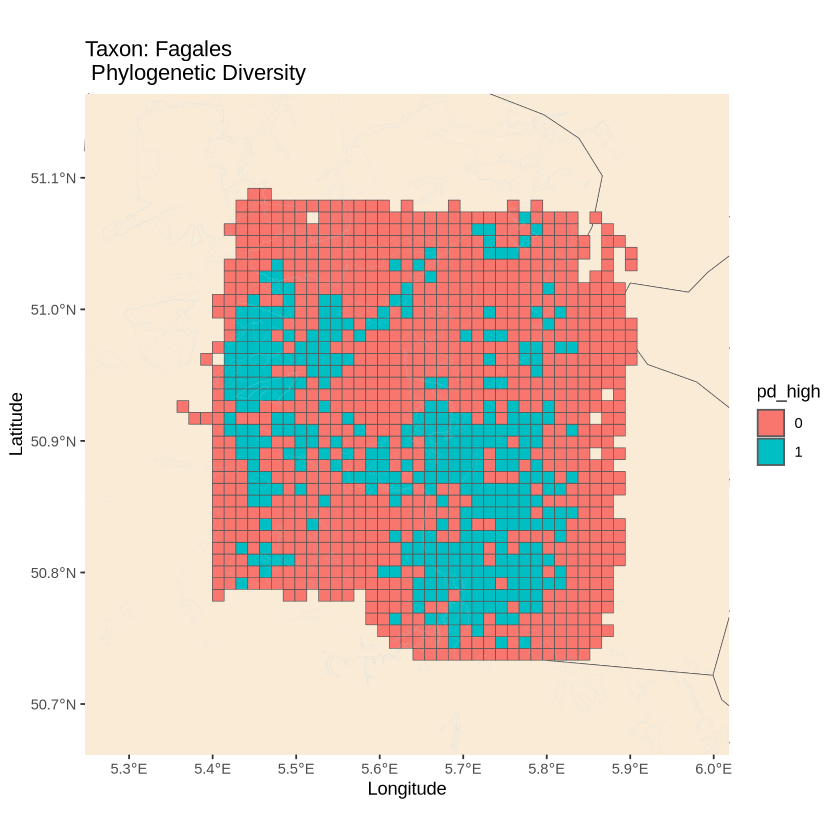

In [22]:
print(plots)

In [24]:
print(paste("The percentage of high PD grid cells that fall within",
                "protected areas is", round(indicators$Overall, digits=2), "%"))

[1] "The percentage of high PD grid cells that fall within protected areas is 23.46 %"
